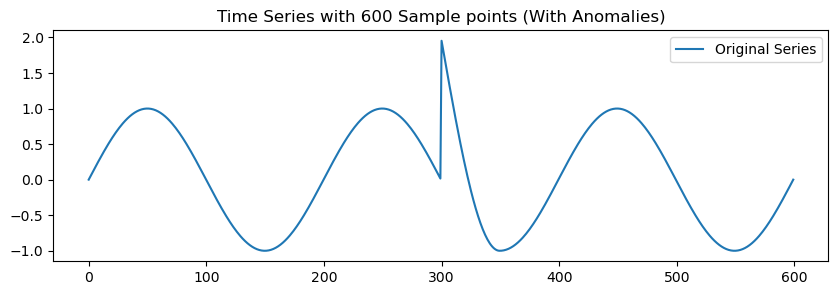

共有 115 個子序列，每個子序列長度 = 30
完成 DTW 距離矩陣計算，形狀 = (115, 115)
分群結果標籤: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
群 -1 的子序列數量: 10
群 0 的子序列數量: 105
離群子序列起始時間點: [275, 280, 285, 290, 295, 300, 305, 310, 315, 320]


c:\Users\jhbai\Anaconda\envs\MachineLearningEnv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


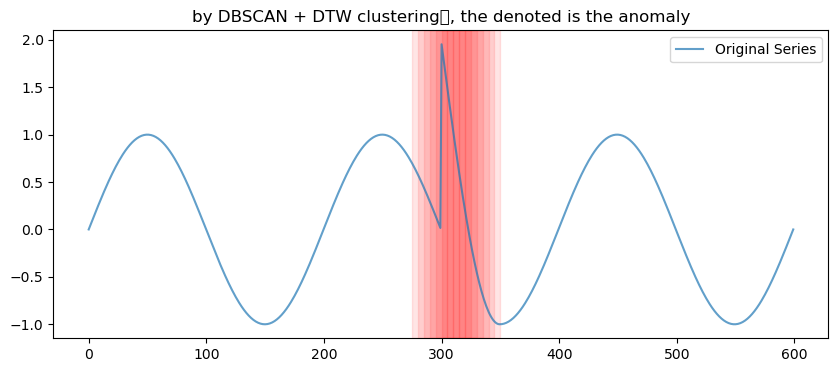

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 如需使用 dtaidistance 計算 DTW 距離
from fastdtw import fastdtw
from sklearn.cluster import DBSCAN


# -------------------------------------------------------------------
# 1. 產生範例時間序列 (可換成實際資料)
# -------------------------------------------------------------------
np.random.seed(42)

# 假設我們產生一些具有不同波形的資料片段，再串成一條長序列
t = np.linspace(0, 6*np.pi, 600)  # 600個點
data = np.sin(t)                  # 基本波形

# 在序列中間插入一段異常波形 (人為製造)
data[300:350] = data[300:350] * 3 + 2  # 放大並上移

plt.figure(figsize=(10, 3))
plt.plot(data, label="Original Series")
plt.legend()
plt.title("Time Series with 600 Sample points (With Anomalies)")
plt.show()


# -------------------------------------------------------------------
# 2. 建立滑動視窗函式 (Sliding Window)
# -------------------------------------------------------------------
def create_sliding_windows(series, window_size=30, step=1):
    """
    將單一路徑的時間序列以滑動視窗方式切割成多個子序列
    :param series: 原始一維時間序列 (list or np.array)
    :param window_size: 視窗大小
    :param step: 滑動步長
    :return: shape = (數量, window_size) 的 2D array
    """
    windows = []
    for start_idx in range(0, len(series) - window_size + 1, step):
        window_data = series[start_idx:start_idx + window_size]
        windows.append(window_data)
    return np.array(windows)


# -------------------------------------------------------------------
# 3. 產生子序列資料
# -------------------------------------------------------------------
window_size = 30
step = 5  # 視窗每次滑動5個點
subsequences = create_sliding_windows(data, window_size=window_size, step=step)

print(f"共有 {len(subsequences)} 個子序列，每個子序列長度 = {window_size}")


# -------------------------------------------------------------------
# 4. 計算 DTW 距離矩陣
# -------------------------------------------------------------------
def compute_dtw_distance_matrix(subseqs):
    """
    計算所有子序列兩兩之間的 DTW 距離，回傳 (N, N) 的對稱矩陣
    :param subseqs: shape = (N, window_size) 的 2D array
    :return: shape = (N, N) 的距離矩陣
    """
    N = len(subseqs)
    dist_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(i+1, N):
            # 計算第 i 與第 j 子序列的 DTW 距離
            dist, _ = fastdtw(subseqs[i], subseqs[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist

    return dist_matrix

dist_matrix = compute_dtw_distance_matrix(subsequences)
print("完成 DTW 距離矩陣計算，形狀 =", dist_matrix.shape)


# -------------------------------------------------------------------
# 5. 以 DBSCAN 進行分群 (無監督)
# -------------------------------------------------------------------
# 設定參數：
#  - eps: DTW 距離閾值 (需根據資料特性做調整)
#  - min_samples: 判定核心點 (core samples) 的鄰居數量
dbscan = DBSCAN(eps=1, min_samples=5, metric='precomputed')
labels = dbscan.fit_predict(dist_matrix)

# 標籤說明：
#  - -1: 表示離群點 (outlier)
#  - 其他非負整數: 表示該子序列所屬的群 (cluster ID)
print("分群結果標籤:", labels)

# 統計各群大小
unique_labels, counts = np.unique(labels, return_counts=True)
for lbl, cnt in zip(unique_labels, counts):
    print(f"群 {lbl} 的子序列數量: {cnt}")

# -------------------------------------------------------------------
# 6. 觀察分群與離群 (異常) 結果
# -------------------------------------------------------------------
# 將子序列對應回原始時間序列的位置，觀察哪段被標記為 -1 (離群點)
anomalies_indices = np.where(labels == -1)[0]

# 為方便顯示，我們簡單統計這些子序列的起始時間點
anomaly_starts = [idx*step for idx in anomalies_indices]
print("離群子序列起始時間點:", anomaly_starts)

# (選擇性) 可將標記為 -1 的子序列視為「潛在異常區段」


# -------------------------------------------------------------------
# 7. 視覺化：將離群子序列在原始序列中做簡易標示
# -------------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(data, label="Original Series", alpha=0.7)

for out_idx in anomalies_indices:
    start_pos = out_idx * step
    end_pos = start_pos + window_size
    plt.axvspan(start_pos, end_pos, color='red', alpha=0.1)

plt.title("by DBSCAN + DTW clustering後, the denoted is the anomaly")
plt.legend()
plt.show()


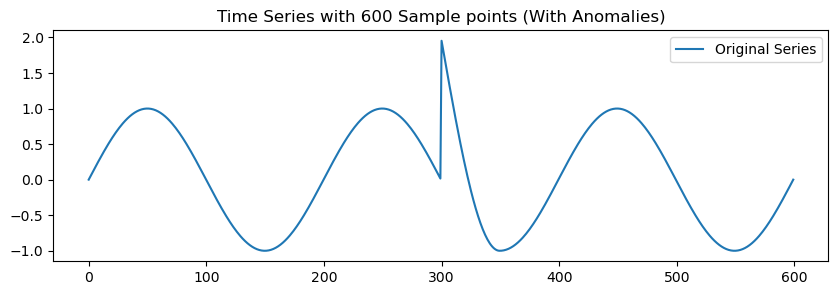

共有 115 個子序列，每個子序列長度 = 30
完成 DTW 距離矩陣計算，形狀 = (115, 115)
分群結果標籤: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
群 -1 的子序列數量: 9
群 0 的子序列數量: 106
離群子序列起始時間點: [275, 280, 285, 290, 295, 300, 305, 310, 315]


c:\Users\jhbai\Anaconda\envs\MachineLearningEnv\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


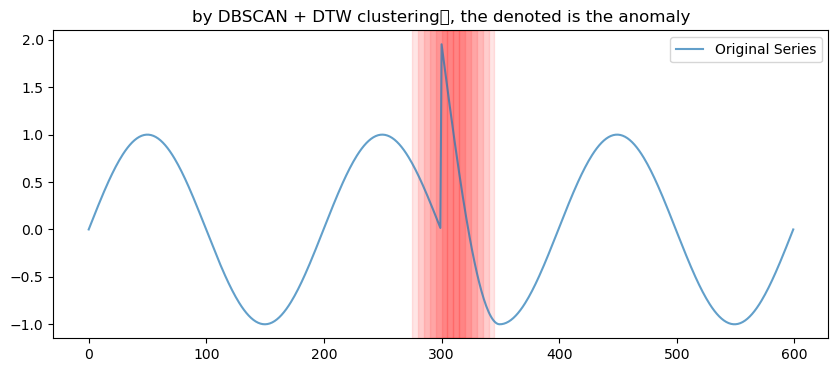

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 如需使用 dtaidistance 計算 DTW 距離
from fastdtw import fastdtw
from sklearn.cluster import DBSCAN


# -------------------------------------------------------------------
# 1. 產生範例時間序列 (可換成實際資料)
# -------------------------------------------------------------------
np.random.seed(42)

# 假設我們產生一些具有不同波形的資料片段，再串成一條長序列
t = np.linspace(0, 6*np.pi, 600)  # 600個點
data = np.sin(t)                  # 基本波形

# 在序列中間插入一段異常波形 (人為製造)
data[300:350] = data[300:350] * 3 + 2  # 放大並上移

plt.figure(figsize=(10, 3))
plt.plot(data, label="Original Series")
plt.legend()
plt.title("Time Series with 600 Sample points (With Anomalies)")
plt.show()


# -------------------------------------------------------------------
# 2. 建立滑動視窗函式 (Sliding Window)
# -------------------------------------------------------------------
def create_sliding_windows(series, window_size=30, step=1):
    """
    將單一路徑的時間序列以滑動視窗方式切割成多個子序列
    :param series: 原始一維時間序列 (list or np.array)
    :param window_size: 視窗大小
    :param step: 滑動步長
    :return: shape = (數量, window_size) 的 2D array
    """
    windows = []
    for start_idx in range(0, len(series) - window_size + 1, step):
        window_data = series[start_idx:start_idx + window_size]
        windows.append(window_data)
    return np.array(windows)


# =============================
# 3. PAA 壓縮函式
# =============================
# https://zh.wikipedia.org/wiki/%E5%88%86%E6%AE%B5%E8%81%9A%E5%90%88%E8%BF%91%E4%BC%BC%E6%B3%95
def paa_transform(sequence, segments=10):
    """
    將長度為 L 的子序列切成 'segments' 等分，每段取平均值，回傳壓縮後的向量 (長度=segments)
    """
    L = len(sequence)
    # 每個 segment 對應多少點
    seg_size = L / segments  
    paa_result = np.zeros(segments)
    
    for i in range(segments):
        start = int(np.floor(i*seg_size))
        end = int(np.floor((i+1)*seg_size))
        # 最後一段可能需要補齊
        end = min(end, L)
        paa_result[i] = np.mean(sequence[start:end])
    
    return paa_result


# -------------------------------------------------------------------
# 4. 產生子序列資料
# -------------------------------------------------------------------
window_size = 30
step = 5  # 視窗每次滑動5個點
subsequences = create_sliding_windows(data, window_size=window_size, step=step)
subsequences = np.array([paa_transform(seq, segments=10) for seq in subsequences])

print(f"共有 {len(subsequences)} 個子序列，每個子序列長度 = {window_size}")


# -------------------------------------------------------------------
# 5. 計算 DTW 距離矩陣
# -------------------------------------------------------------------
def compute_dtw_distance_matrix(subseqs):
    """
    計算所有子序列兩兩之間的 DTW 距離，回傳 (N, N) 的對稱矩陣
    :param subseqs: shape = (N, window_size) 的 2D array
    :return: shape = (N, N) 的距離矩陣
    """
    N = len(subseqs)
    dist_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(i+1, N):
            # 計算第 i 與第 j 子序列的 DTW 距離
            dist, _ = fastdtw(subseqs[i], subseqs[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist

    return dist_matrix

dist_matrix = compute_dtw_distance_matrix(subsequences)
print("完成 DTW 距離矩陣計算，形狀 =", dist_matrix.shape)


# -------------------------------------------------------------------
# 6. 以 DBSCAN 進行分群 (無監督)
# -------------------------------------------------------------------
# 設定參數：
#  - eps: DTW 距離閾值 (需根據資料特性做調整)
#  - min_samples: 判定核心點 (core samples) 的鄰居數量
dbscan = DBSCAN(eps=1, min_samples=5, metric='precomputed')
labels = dbscan.fit_predict(dist_matrix)

# 標籤說明：
#  - -1: 表示離群點 (outlier)
#  - 其他非負整數: 表示該子序列所屬的群 (cluster ID)
print("分群結果標籤:", labels)

# 統計各群大小
unique_labels, counts = np.unique(labels, return_counts=True)
for lbl, cnt in zip(unique_labels, counts):
    print(f"群 {lbl} 的子序列數量: {cnt}")

# -------------------------------------------------------------------
# 7. 觀察分群與離群 (異常) 結果
# -------------------------------------------------------------------
# 將子序列對應回原始時間序列的位置，觀察哪段被標記為 -1 (離群點)
anomalies_indices = np.where(labels == -1)[0]

# 為方便顯示，我們簡單統計這些子序列的起始時間點
anomaly_starts = [idx*step for idx in anomalies_indices]
print("離群子序列起始時間點:", anomaly_starts)

# (選擇性) 可將標記為 -1 的子序列視為「潛在異常區段」


# -------------------------------------------------------------------
# 8. 視覺化：將離群子序列在原始序列中做簡易標示
# -------------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(data, label="Original Series", alpha=0.7)

for out_idx in anomalies_indices:
    start_pos = out_idx * step
    end_pos = start_pos + window_size
    plt.axvspan(start_pos, end_pos, color='red', alpha=0.1)

plt.title("by DBSCAN + DTW clustering後, the denoted is the anomaly")
plt.legend()
plt.show()


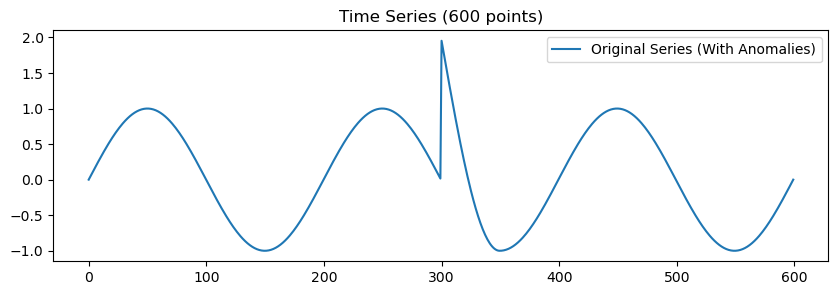

共有 115 個子序列, 每個長度=30
第一階段 (PAA+歐幾里得) 分群結果: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
第一階段潛在異常子序列數量: 3
第二階段(DTW)最終異常子序列索引: []


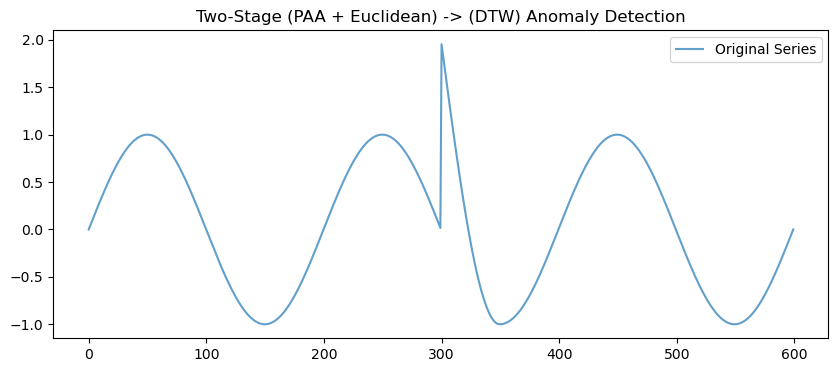

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# fastdtw 用於第二階段精細計算
from fastdtw import fastdtw
# DBSCAN 用於第一階段與第二階段的分群
from sklearn.cluster import DBSCAN

# =============================
# 1. 產生範例時間序列
# =============================
np.random.seed(42)
t = np.linspace(0, 6*np.pi, 600)  
data = np.sin(t)
# 製造一段異常
data[300:350] = data[300:350] * 3 + 2

plt.figure(figsize=(10, 3))
plt.plot(data, label="Original Series (With Anomalies)")
plt.legend()
plt.title("Time Series (600 points)")
plt.show()

# =============================
# 2. Sliding Window 函式
# =============================
def create_sliding_windows(series, window_size=30, step=5):
    windows = []
    for start_idx in range(0, len(series) - window_size + 1, step):
        window_data = series[start_idx:start_idx + window_size]
        windows.append(window_data)
    return np.array(windows)

# =============================
# 3. PAA 壓縮函式
# =============================
def paa_transform(sequence, segments=10):
    """
    將長度為 L 的子序列切成 'segments' 等分，每段取平均值，回傳壓縮後的向量 (長度=segments)
    """
    L = len(sequence)
    # 每個 segment 對應多少點
    seg_size = L / segments  
    paa_result = np.zeros(segments)
    
    for i in range(segments):
        start = int(np.floor(i*seg_size))
        end = int(np.floor((i+1)*seg_size))
        # 最後一段可能需要補齊
        end = min(end, L)
        paa_result[i] = np.mean(sequence[start:end])
    
    return paa_result

# =============================
# 4. 產生子序列 & 第一階段壓縮
# =============================
window_size = 30
step = 5
subsequences = create_sliding_windows(data, window_size=window_size, step=step)
N = len(subsequences)
print(f"共有 {N} 個子序列, 每個長度={window_size}")

# 將每個子序列都做 PAA 壓縮 (segments=10 可自行調整)
segments = 10
paa_subseqs = np.array([paa_transform(seq, segments=segments) for seq in subsequences])

# =============================
# 5. 第一階段: PAA + 歐幾里得距離 + DBSCAN
# =============================
# 先計算歐幾里得距離矩陣 (在 PAA 空間, 維度較小, 計算會快一點)
dist_matrix_paa = np.zeros((N, N), dtype=float)

for i in range(N):
    for j in range(i+1, N):
        dist = np.linalg.norm(paa_subseqs[i] - paa_subseqs[j])  # 歐幾里得距離
        dist_matrix_paa[i, j] = dist
        dist_matrix_paa[j, i] = dist

# 在第一階段中, eps 可稍微寬鬆, 主要目標是抓出"可疑"者
dbscan_1 = DBSCAN(eps=1.5, min_samples=5, metric='precomputed')
labels_1 = dbscan_1.fit_predict(dist_matrix_paa)

print("第一階段 (PAA+歐幾里得) 分群結果:", labels_1)

# 找出第一階段標記為 -1 的子序列 => 可能異常
stage1_outliers = np.where(labels_1 == -1)[0]
print("第一階段潛在異常子序列數量:", len(stage1_outliers))

# =============================
# 6. 第二階段: 對"可疑子序列"做 DTW 精細檢測
# =============================
# 假設我們只對第一階段的 outliers 做 DTW 分群
suspect_subseqs = subsequences[stage1_outliers]
M = len(suspect_subseqs)
if M > 0:
    dist_matrix_dtw = np.zeros((M, M), dtype=float)
    for i in range(M):
        for j in range(i+1, M):
            dist, _ = fastdtw(suspect_subseqs[i], suspect_subseqs[j])
            dist_matrix_dtw[i, j] = dist
            dist_matrix_dtw[j, i] = dist
    
    # 第二階段: 用較小 eps, 嚴格判斷
    dbscan_2 = DBSCAN(eps=15, min_samples=3, metric='precomputed')
    labels_2 = dbscan_2.fit_predict(dist_matrix_dtw)
    
    # labels_2 是針對 stage1_outliers 這些子序列的分群結果
    final_outlier_indices = np.where(labels_2 == -1)[0]  # 在第二階段仍被標記為 -1
    final_outliers_global = stage1_outliers[final_outlier_indices]  # 對應回全局子序列的索引
else:
    # 若第一階段沒有可疑子序列, 就不需要第二階段
    labels_2 = np.array([])
    final_outliers_global = np.array([])

print("第二階段(DTW)最終異常子序列索引:", final_outliers_global)

# =============================
# 7. 統整: 視覺化標記最終異常
# =============================
plt.figure(figsize=(10, 4))
plt.plot(data, label="Original Series", alpha=0.7)

for out_idx in final_outliers_global:
    start_pos = out_idx * step
    end_pos = start_pos + window_size
    plt.axvspan(start_pos, end_pos, color='red', alpha=0.2)

plt.title("Two-Stage (PAA + Euclidean) -> (DTW) Anomaly Detection")
plt.legend()
plt.show()
